In [22]:
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [23]:
# Download MNIST
(X_train, Y_train), (X_test, _) = mnist.load_data()

# Print the shape of train dataset
print(X_train.shape)

(60000, 28, 28)


In [24]:
# Flatten the images
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)
print(X_train.shape)

# Normalize data
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

(60000, 784)


In [25]:
# Try K-Means clustering
n_clusters = 10
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train)

MiniBatchKMeans(n_clusters=10, random_state=42)

In [26]:
def associate_labels(n_clusters, kmeans_clusters, Y_train):
    true_labels = {}
    for i in range(len(np.unique(kmeans_clusters))):
        indices = np.where(kmeans_clusters == i)
        digit = np.bincount(Y_train[indices]).argmax()
        true_labels[i] = digit
    return true_labels

true_labels = associate_labels(n_clusters, kmeans.labels_, Y_train)
print(true_labels)

{0: 4, 1: 9, 2: 3, 3: 0, 4: 1, 5: 0, 6: 6, 7: 3, 8: 7, 9: 2}


In [27]:
kmeans_labels = np.zeros(Y_train.shape)
for i in range(len(kmeans.labels_)):
    kmeans_labels[i] = true_labels[kmeans.labels_[i]]
print(accuracy_score(kmeans_labels,Y_train))

0.5558833333333333


5
10
36
64
256
360


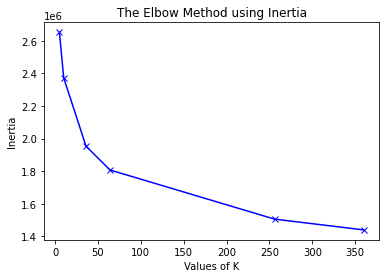

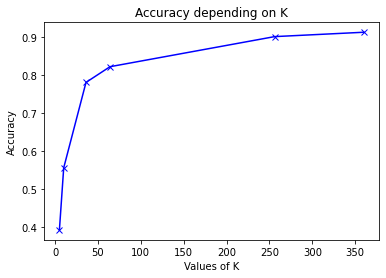

In [28]:
# Technically, increasing n_cluster will give better results
def test_different_Ks(X):
    accuracies = []
    inertias = []
    K = [5, 10, 36, 64, 256, 360]

    for k in K:
        print(k)
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)

        inertias.append(kmeans.inertia_)
        true_labels = associate_labels(n_clusters, kmeans.labels_, Y_train)
        kmeans_labels = np.zeros(Y_train.shape)
        for i in range(len(kmeans.labels_)):
            kmeans_labels[i] = true_labels[kmeans.labels_[i]]
        accuracies.append(accuracy_score(kmeans_labels,Y_train))

    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()

    plt.plot(K, accuracies, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Accuracy')
    plt.title('Accuracy depending on K')
    plt.show()

test_different_Ks(X_train)

In [29]:
# Train Convolutional AutoEncoder
tf.random.set_seed(42)

input_img = keras.Input(shape=(28, 28, 1))

x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

cae = keras.Model(input_img, decoded)
cae.compile(optimizer='adam', loss='binary_crossentropy')
print(cae.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [ ]:
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))

cae.fit(X_train, X_train, epochs=50, batch_size=128, shuffle=True, validation_data=(X_test, X_test), verbose=1)

In [ ]:
# Retry K-Means clustering on CAE encoding

encoder = keras.Model(input_img, encoded)
encoded_X_train = encoder.predict(X_train)

test_different_Ks(encoded_X_train)